# Larsen Ice Shelf

This demo will involve using real data for the Larsen Ice Shelf in the Antarctic Peninsula.
The use of real data will mostly change how we set up the simulation.
The simulation itself -- involving successive prognostic and diagnostic solves of the physics model -- is virtually identical to what we saw in the last demo.

To access the data, you'll need to have a login for [EarthData](https://urs.earthdata.nasa.gov/), the web portal through which NASA makes remote sensing data available to the public.
Most of the ice sheet remote sensing data produced by American research institutions is hosted at the [National Snow and Ice Data Center (NSIDC)](https://www.nsidc.org) and an EarthData login is necessary to access data from NSIDC.

The external data that we will use are:

* the [BedMachine](https://nsidc.org/data/NSIDC-0756/versions/1) thickness map of Antarctica
* a velocity map of Antarctica produced as part of the MEaSUREs program, which you can read more about [here](https://nsidc.org/data/nsidc-0484)
* a satellite image of all of Antarctica taken from [MODIS](https://en.wikipedia.org/wiki/Moderate_Resolution_Imaging_Spectroradiometer)
* an outline of the Larsen C Ice Shelf, which I created by tracing over this satellite image in a [geographic information system](https://en.wikipedia.org/wiki/Geographic_information_system).

Rather than manually download these data sets from the websites they're hosted on, we'll call a few functions in the module `icepack.datasets` to fetch them for us.
(Internally, these functions use a library called [pooch](https://github.com/fatiando/pooch) which handles things like caching the data so it doesn't get downloaded twice, unzipping archived files, and so forth.)
One we have these data sets we'll use the library [rasterio](https://rasterio.readthedocs.io/en/stable/) to read the gridded data and [GeoJSON](https://github.com/jazzband/python-geojson) for the vector data.
Pooch, rasterio, and GeoJSON will have been installed along with icepack, so you don't need to do this yourself.

### Geometry

First, we'll fetch a [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON) file describing the outline of the domain.
GeoJSON is a common file format for geospatial vector data.
In the previous demo, we generated a .geo file describing the outline of the domain, and then called gmsh to create a triangulation of the interior.
For this demo, we'll use a different helper script that will turn our .geojson file into the .geo format that gmsh expects.

To retrieve the external data, we'll use several functions in the module `icepack.datasets`.
All of these functions start with `fetch`.
These functions retrieve the external data from the internet and put them in a predictable location so they can be found easily later.
The files will only be downloaded the first time you fetch them.
This caching functionality will come in handy because we'll be using much of the same data in later demos.

In [1]:
import icepack
outline_filename = icepack.datasets.fetch_outline('larsen')
print(outline_filename)

/home/daniel/.cache/icepack/larsen.geojson


To read this file we'll use the GeoJSON package.
We won't go into a great amount of detail about analyzing geospatial vector data here, but a few basic features are worth going over.

In [2]:
import geojson
with open(outline_filename, 'r') as outline_file:
    outline = geojson.load(outline_file)

From the user's perspective, a GeoJSON object looks like a big nested dictionary, and somewhere down the line are some arrays of coordinates.
Here we'll access the [coordinate reference system (CRS)](https://en.wikipedia.org/wiki/Spatial_reference_system) that the data are stored in.
The most common reference systems are standardized and given numeric ID codes by a standards body, the European Petroleum Survey Group (EPSG).
The most common CRS for Antarctic data sets is EPSG:3031, a stereographic projection centered on the South Pole.

In [3]:
print(outline['crs']['properties']['name'])

urn:ogc:def:crs:EPSG::3031


The data we care about in this GeoJSON object are the coordinates of all the features.
Here we'll compute a bounding box for the domain to illustrate how one iterates over all of the features.
In this case, every feature of this object is a `MultiLineString`.

In [4]:
import numpy as np
features = [feature['geometry'] for feature in outline['features']]
xmin, ymin, xmax, ymax = np.inf, np.inf, -np.inf, -np.inf
δ = 50e3
for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        x, y = xs[:, 0], xs[:, 1]
        xmin, ymin = min(xmin, x.min() - δ), min(ymin, y.min() - δ)
        xmax, ymax = max(xmax, x.max() + δ), max(ymax, y.max() + δ)
        
print(f'{xmin:e}, {ymin:e}, {xmax:e}, {ymax:e}')

-2.384857e+06, 9.358604e+05, -1.946497e+06, 1.325843e+06


We can plot the domain outline below to see that everything lines up right.

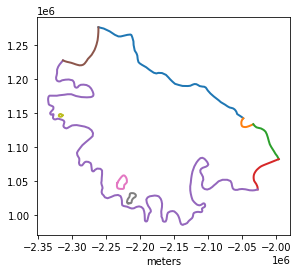

In [5]:
import icepack.plot
fig, axes = icepack.plot.subplots()

for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters');

But without some additional context you might not know what each segment of the boundary corresponds to on the real ice shelf.
To make that context more apparent, we'll show how to plot things on top of satellite imagery next.

### Imagery

We'll use the [Mosaic of Antarctica (MOA)](https://nsidc.org/data/moa) as a background for all the plots we make in the following.
This mosaic was created by compiling several hundred images from [MODIS](https://en.wikipedia.org/wiki/Moderate_Resolution_Imaging_Spectroradiometer).
We could also use imagery from other satellites like Landsat-8 if we wanted higher spatial or radiometric resolution.

The image mosaic is stored as a [GeoTIFF](https://en.wikipedia.org/wiki/GeoTIFF) file.
GeoTIFF is a common storage format for geospatial data; it adds georeferencing information on top of the TIFF file format, which is often used for lossless compression of images.
The function `rasterio.open` will give us an object representing the raster data set that we can then read from.

In [6]:
import rasterio
image_filename = icepack.datasets.fetch_mosaic_of_antarctica()
image_file = rasterio.open(image_filename, 'r')

We've opened the file but we haven't read any data yet.
The image file covers all of Antarctica, so it would be wasteful to read the entire image.
Instead, we'll read a window that covers the bounding box we calculated above.

In [7]:
height, width = image_file.height, image_file.width
transform = image_file.transform
window = rasterio.windows.from_bounds(
    left=xmin, bottom=ymin, right=xmax, top=ymax,
    width=width, height=height, transform=transform
)

Now we can pass the window to the `read` method of `image_file`, which will return a numpy array of the image values over the area that we want.
The `indexes` argument specifies that we're reading only band 1; since this is a grayscale image, that's all we can read.
For RGB or other multi-spectral images, you might want to get more of the spectral bands.

In [8]:
image = image_file.read(indexes=1, window=window, masked=True)

Now we can make a figure showing the image of the Larsen Ice Shelf together with the various segments of the domain boundary.
To add in the spatial coordinates of all the image pixels, we've passed in the bounding box of the window that we created earlier to `imshow` via the keyword `extent`.
The `vmin` and `vmax` arguments were tuned by trial and error to get a nice contrast level.
You can make out where the ice is grounded or floating, where there are ice rises, and if you change the balance quite a bit you can even pick out rifts in the ice shelf.

In [9]:
def subplots(*args, **kwargs):
    fig, axes = icepack.plot.subplots()
    xmin, ymin, xmax, ymax = rasterio.windows.bounds(window, transform)
    axes.imshow(
        image,
        cmap='Greys_r',
        vmin=12e3,
        vmax=16.38e3,
        extent=(xmin, xmax, ymin, ymax)
    )
    
    return fig, axes

We'll use this satellite image on every plot in this demo.
Rather than add the same boilerplate code every time, the code above defines a wrapper function that creates figure and axes objects and adds the image to the plot.

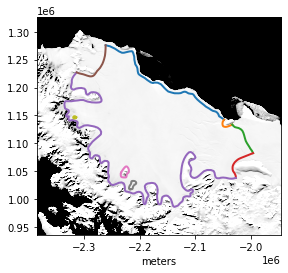

In [10]:
fig, axes = subplots()

for feature in outline['features']:
    for line_string in feature['geometry']['coordinates']:
        xs = np.array(line_string)
        axes.plot(xs[:, 0], xs[:, 1], linewidth=2)

axes.set_xlabel('meters');

Checking that the domain boundary lines up well with features that are visible in the satellite image is a good sanity check.
This way we know that the coordinate systems haven't been mixed up, that you haven't accidentally loaded up a mesh of a totally different ice shelf, and so forth.

### Meshing

Next we'll take this GeoJSON object and translate it into a geometry object from pygmsh.
The function to do that is contained in the module `icepack.meshing`.
We can then save this to a .geo file and run gmsh on the result, just like we did in the previous demo.

In [11]:
geometry = icepack.meshing.collection_to_geo(outline)

In [12]:
with open('larsen.geo', 'w') as geo_file:
    geo_file.write(geometry.get_code())

The call to gmsh is the same as in the previous demo, but we'll make the output less verbose by passing the flag `-v 2` as well.

In [13]:
!gmsh -2 -format msh2 -v 2 -o larsen.msh larsen.geo

Now that we've generated the mesh we can read it just like we did in the previous demo.

In [14]:
import firedrake
mesh = firedrake.Mesh('larsen.msh')

Finally we'll make a plot of the mesh so that we can see all the boundary IDs.
Boundary segments 1 and 3 correspond to the calving terminus and these are where Neumann boundary conditions should be applied.
Segment 2 borders the Gipps Ice Rise, and the remaining segments are where ice is flowing in from.
To make things a little clearer visually we're also specifying a muuch smaller line weight for the interior edges compared to the boundary edges.

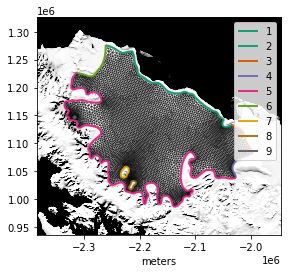

In [15]:
fig, axes = subplots()
axes.set_xlabel('meters')
kwargs = {
    'interior_kw': {'linewidth': .25},
    'boundary_kw': {'linewidth': 2}
}
icepack.plot.triplot(mesh, axes=axes, **kwargs)
axes.legend();

### Input data

Next, we have to load the input data, starting with the ice thickness.
The BedMachine Antarctica dataset is hosted on NSIDC; the function `fetch_bedmachine_antarctica` will prompt you for your EarthData login if need be and download the dataset from the internet.

In [16]:
thickness_filename = icepack.datasets.fetch_bedmachine_antarctica()

The data are stored in a [NetCDF](https://en.wikipedia.org/wiki/NetCDF) file.
NetCDF is a common storage format for geophysical data, especially in atmospheric science.
NetCDF offers a lot more freedom than GeoTIFF in terms of what kind of data can be stored and how, so you have to know something about the schema or layout before you use it.
For example, many fields can be stored by name in a NetCDF file, and you have to know what all the names are.
The script `ncinfo` will print out information about all the fields stored in a NetCDF file.

In [17]:
!ncinfo "$thickness_filename"

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.7
    Title: BedMachine Antarctica
    Author: Mathieu Morlighem
    version: 15-Jul-2020 (v2.0)
    nx: 13333.0
    ny: 13333.0
    Projection: Polar Stereographic South (71S,0E)
    proj4: +init=epsg:3031
    sea_water_density (kg m-3): 1027.0
    ice_density (kg m-3): 917.0
    xmin: -3333000
    ymax: 3333000
    spacing: 500
    no_data: -9999.0
    license: No restrictions on access or use
    Data_citation: Morlighem M. et al., (2019), Deep glacial troughs and stabilizing ridges unveiled beneath the margins of the Antarctic ice sheet, Nature Geoscience (accepted)
    Notes: Data processed at the Department of Earth System Science, University of California, Irvine
    dimensions(sizes): x(13333), y(13333)
    variables(dimensions): |S1 mapping(), int32 x(x), int32 y(y), int8 mask(y, x), float32 firn(y, x), float32 surface(y, x), float32 thickness(y, x), float32 bed(

From this information we can see that the name of the field we want is `thickness`.
We can use rasterio to read NetCDF files, but we have to add in a bit of extra magic so that it knows which field to extract from the file.
To specify which field we're reading, we can prepend `netcdf:` to the beginning of the filename and append `:FIELD_NAME` to the string we pass to `rasterio.open`.

In [18]:
thickness = rasterio.open(f'netcdf:{thickness_filename}:thickness', 'r')

Next, we have to fetch the velocity data, which are also hosted on NSIDC.
The file is ~6GiB, so if you run this demo yourself, this step could take a while.

In [19]:
velocity_filename = icepack.datasets.fetch_measures_antarctica()

The fields we want are `VX` and `VY`.
The velocity dataset is also stored as a NetCDF file; the names of the fields we want are `VX` and `VY`.

In [20]:
vx = rasterio.open(f'netcdf:{velocity_filename}:VX', 'r')
vy = rasterio.open(f'netcdf:{velocity_filename}:VY', 'r')

### Modeling

Having done all the leg work to make a mesh and get a good set of input data, the modeling itself should be fairly familiar from the last step.
We'll assume that the ice temperature is a uniform -13C.

One thing is substantially different from previous examples.
Before, we called the function `firedrake.SpatialCoordinate` to get some symbolic handles `x, y` for the mesh coordinates, and we created symbolic expressions to define the input data to our problem analytically.
Now that we're working with real glaciers, we're reading in all the observational data using rasterio, but Firedrake doesn't know how to interpolate a rasterio dataset.
The function `icepack.interpolate` works as a layer on top of the firedrake interpolate function and knows what to do with gridded data sets.

In [21]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)
V = firedrake.VectorFunctionSpace(mesh, family='CG', degree=2)

h0 = icepack.interpolate(thickness, Q)
u0 = icepack.interpolate((vx, vy), V)

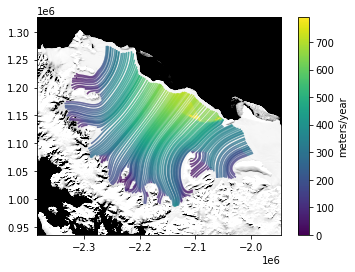

In [22]:
fig, axes = subplots()
streamlines = icepack.plot.streamplot(
    u0, precision=1000, density=2500, axes=axes
)
fig.colorbar(streamlines, label='meters/year');

We'll set up the model in the same way as the synthetic ice shelf demo, but there are more boundary segments for which we need to apply Dirichlet conditions.

In [23]:
T = firedrake.Constant(260)
A = icepack.rate_factor(T)
model = icepack.models.IceShelf()
opts = {'dirichlet_ids': [2, 4, 5, 6, 7, 8, 9], 'tolerance': 1e-6}
solver = icepack.solvers.FlowSolver(model, **opts)

Next, we'll try to solve the shallow shelf equations to obtain the initial ice velocity.

In [24]:
try:
    u = solver.diagnostic_solve(
        velocity=u0,
        thickness=h0,
        fluidity=A
    )
except:
    print('Oh no, nonlinear solver did not converge!')

Oh no, nonlinear solver did not converge!


And now we've got our first taste of how difficult working with real data can be!
Why did the nonlinear solver fail to converge?
The ice thickness map from BedMachine is fine enough to resolve pretty small-scale topography, even down to the depth of rifts in the ice shelf.
Having such a high-resolution dataset means that the thickness can jump over a very small distance.
This could result in an unphysically large driving stress, which is shown in the plot below.

In [25]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    gravity as g
)
from firedrake import grad
τ_d = firedrake.interpolate(
    -1e3 * ρ_I * g * (1 - ρ_I / ρ_W) * grad(h0**2), V
)

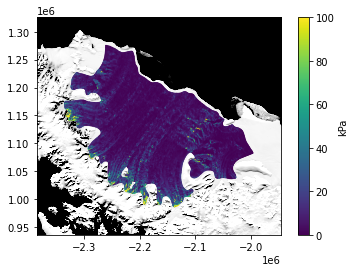

In [26]:
fig, axes = subplots()
colors = icepack.plot.tripcolor(τ_d, vmin=0, vmax=100, axes=axes)
fig.colorbar(colors, label='kPa');

In many regions the driving stress exceeds 100 kilopascals, which would be reasonable for a steep Greenland outlet glacier, not for a floating ice shelf.

A quick hack around this would be to synthesize a new, smoother thickness field makes that matches the direct observations as well as possible.
In other words, we want a field $h$ that minimizes the following functional:

$$J(h) = \frac{1}{2}\int_\Omega\left((h - h^o)^2 + \alpha^2|\nabla h|^2\right)dx.$$

The first term quantifies the degree to which our modeled thickness $h$ matches the observations $h^o$, while the second term quantifies how oscillatory $h$ is.
The factor $\alpha$ is a length that dictates the distance over which we want to penalize sharp oscillations.
I came up with a smoothing length of 2km by trial and error.
The following code will find a minimizer of $J$ by looking for a thickness at which the derivative of $J$ is zero.

In [27]:
from firedrake import assemble, inner, dx
h = h0.copy(deepcopy=True)
α = firedrake.Constant(2e3)
J = 0.5 * (h - h0)**2 * dx + 0.5 * α**2 * inner(grad(h), grad(h)) * dx
F = firedrake.derivative(J, h)
firedrake.solve(F == 0, h)

The relative difference between the raw and smoothed thickness is around 3%.
That's not a huge relative error; the corrections for tides or for air or water in the firn column are comparable.

In [28]:
print(assemble(abs(h - h0) * dx) / assemble(h * dx))

0.0317023069977651


Finally, the driving stress of the filtered ice thickness tops out around 20 kPa, which is much more reasonable.

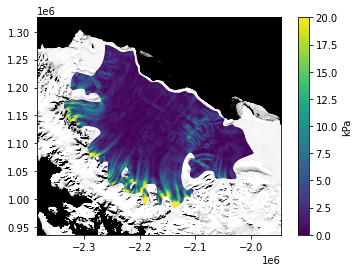

In [29]:
τ_d = firedrake.interpolate(
    -1e3 * ρ_I * g * (1 - ρ_I / ρ_W) * grad(h**2), V
)
fig, axes = subplots()
colors = icepack.plot.tripcolor(τ_d, vmin=0, vmax=20, axes=axes)
fig.colorbar(colors, label='kPa');

With this regularized input data the nonlinear solver converges.
In general, the nonlinear solvers in icepack should always converge on reasonable input data, and sometimes even on unreasonable data too.
A sharp gradient in an overly-resolved thickness field, however, will create such large driving stresses as to no longer be reasonable.

In [30]:
u = solver.diagnostic_solve(
    velocity=u0, 
    thickness=h,
    fluidity=A
)

The computed velocity is shown below; the result looks pretty reasonable if we're going by the speeds.

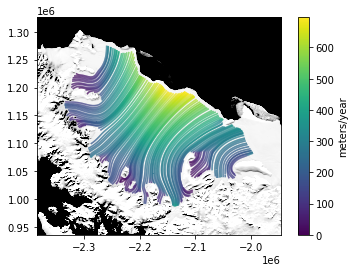

In [31]:
fig, axes = subplots()
streamlines = icepack.plot.streamplot(
    u, precision=1000, density=2500, axes=axes
)
fig.colorbar(streamlines, label='meters/year');

As a further sanity check, we can see how far off the computed velocity is from the observed values.
We get a fairly reasonable approximation even with a spatially homogeneous guess for the ice temperature.

In [32]:
print(icepack.norm(u - u0) / icepack.norm(u0))

0.1821530589722099


Ballpark estimate, the surface and basal mass balance of Larsen C are +30 and -30 cm/yr respectively, so we can take the total to be 0.
Let's simulate the evolution of the ice shelf for the next 10 years.
The code for this loop should be familiar from the previous example.

In [33]:
import tqdm
a = firedrake.Function(Q)
h_init = h.copy(deepcopy=True)

final_time = 10.
num_steps = 40
dt = final_time / num_steps
for step in tqdm.trange(num_steps):
    h = solver.prognostic_solve(
        dt,
        thickness=h,
        velocity=u,
        accumulation=a,
        thickness_inflow=h_init
    )
    
    u = solver.diagnostic_solve(
        velocity=u, 
        thickness=h,
        fluidity=A
    )

100%|███████████████████████████████████████████| 40/40 [00:59<00:00,  1.49s/it]


In the plot below we're using the `alpha` keyword argument to the contouring function.
This makes the thickness contours about half-way transparent so we can see the satellite image underneath.

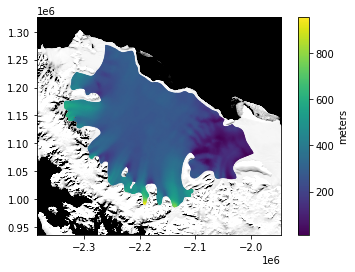

In [34]:
fig, axes = subplots()
colors = icepack.plot.tripcolor(h, axes=axes)
fig.colorbar(colors, label='meters');

By plotting the difference between the modeled thickness after 10 years and the initial thickness, we can see the propagation of the rifts downstream.
This effect is best visualized with a diverging colormap that makes the 0-contour really obvious.

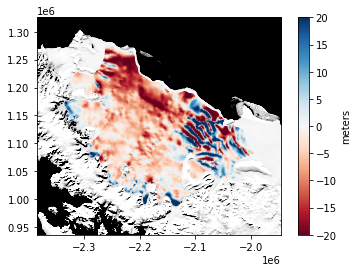

In [35]:
δh = firedrake.Function(Q)
δh.assign(h - h_init)

fig, axes = subplots()
contours = firedrake.tripcolor(
    δh, vmin=-20, vmax=+20, axes=axes, cmap='RdBu'
)
fig.colorbar(contours, label='meters');

The greatest mass losses occurred nearest to the calving terminus.
The pattern in mass change near the rifts on the right edge of the domain is more from advecting those oscillations downstream.
From the overall pattern, it's clear that the ice shelf is losing mass.
To see exactly how much, we can integrate the total thickness change and divide by the area of the shelf.

In [36]:
area = assemble(firedrake.Constant(1) * dx(mesh))
print(assemble(δh * dx) / area)

-3.7871115017439094


Seeing as the simulation ran for 10 years, this isn't a wildly unrealistic number.
Instead of guessing the net accumulation rate, we could improve the fidelity of our simulation by forcing it with the output of a climate model.

### Conclusion

In the last demo, we showed how to simulate ice shelf flow using synthetic data.
Here we showed how to load in a generated mesh and observational data, and we used this same functionality to simulate a real ice shelf.

Many real data sets require some amount of preprocessing before they can be used for modeling.
For example, many velocity data sets have missing pixels or patches due to noise in the optical or radar imagery, and these missing points have to be filled in somehow.
The Bedmap2 thickness also contains processing artifacts that are visible as depressions running diagonally across the ice shelf.
These artifacts could be removed by using a low-pass filter on the gridded data, although this might also wash out some real features like the many rifts in the ice.

In order to run the simulation, we had to come up with a guess for the ice rheology.
The simple choice we made is quite far from the real value and in a subsequent demo we'll show how to estimate it from observational data.